In [1]:
library(Seurat)
library(SeuratDisk)
library(NMF)
library(ggalluvial)
library(ComplexHeatmap)
library(CellChat)
library(patchwork)
library(graphics)
library(Matrix)
library(circlize)
library(colorspace)
library(pracma)
library(glue)

options(stringsAsFactors = FALSE, repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)

source("../Scripts/C-ligand_receptorGenes-diff.r")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')

Loading required package: ggplot2

Loading required package: grid

ComplexHeatmap version 2.15.4
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correla

# Parameters

In [2]:
# for plotting figC, differential network
disease = "AD"
project = "AD_Paper"
type <- "truncatedMean"
trim <- 0.05

pathways.show = "NRG"
thresh <- 0.05

In [3]:
#celltype_name = c('Astro', 'Endo', 'MG', 'Oligo', 'OPC', 
#                  'Exc CUX2', 'Exc FEZF2', 'Exc OPRK1', 'Exc RORB', 
#                  'Inh KCNG1', 'Inh LAMP5', 'Inh PVALB', 'Inh SST', 'Inh VIP')


inhibitory_celltypes <- c('Chandelier', 'Lamp5', 'Lamp5 Lhx6', 'Pax6', 'Pvalb', 'Sncg', 'Sst', 'Vip', 'Sst Chodl')
excitatory_celltypes <- c('L2/3 IT', 'L4 IT', 'L5', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b')
support_celltypes <- c('Astro', 'Endo', 'Oligo', 'OPC', 'VLMC', 'Micro/PVM')
celltype_name = c('Chandelier', 'Lamp5', 'Lamp5 Lhx6', 'Pax6', 'Pvalb', 'Sncg', 'Sst', 'Vip', 'Sst Chodl', 
                  'L2/3 IT', 'L4 IT', 'L5', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 
                  'Astro', 'Endo', 'Oligo', 'OPC', 'VLMC', 'Micro/PVM')

senders <- celltype_name
receivers <- celltype_name

In [4]:
cellchat.CT <- readRDS(file = "/extra/zhanglab0/CommonData/AMP-AD/Obj-CellChat/subclass_cellchat_control.rds")
cellchat.DIS <- readRDS(file = "/extra/zhanglab0/CommonData/AMP-AD/Obj-CellChat/subclass_cellchat_alz.rds")

In [5]:
cellchat.CT <- updateCellChat(cellchat.CT)
cellchat.DIS <- updateCellChat(cellchat.DIS)

Warning message in updateCellChat(cellchat.CT):
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`!”
Warning message in updateCellChat(cellchat.DIS):
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`!”


In [6]:
object.list <- list(CT = cellchat.CT, DIS = cellchat.DIS)
cellchat <- mergeCellChat(object.list, add.names = names(object.list))
print(cellchat)
names(object.list)

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



An object of class CellChat created from a merged object with multiple datasets 
 704 signaling genes.
 51171 cells. 
CellChat analysis of single cell RNA-seq data! 


[1] "CT"  "DIS"

### Yutong's Code

In [33]:
#object.list <- list(CT = cellchat.CT, DIS = cellchat.DIS)
#cellchat <- mergeCellChat(object.list, add.names = names(object.list))
myVisual_diffInteraction <- function(object, celltype_name, comparison = c(1,2), measure = c("count", "weight", "count.merged", "weight.merged"), node.color = c("input", "output"), color.use = NULL, color.edge = c('#b2182b','#2166ac'), title.name = NULL, title.cex = 1.1, sources.use = NULL, targets.use = NULL, remove.isolate = FALSE, top = 1,
                                      weight.scale = FALSE, vertex.weight = 20, vertex.weight.max = NULL, vertex.size.max = 15, vertex.label.cex=1,vertex.label.color= "black",
                                      edge.weight.max = NULL, edge.width.max=8, alpha.edge = 0.6, label.edge = FALSE,edge.label.color='black',edge.label.cex=0.8,
                                      edge.curved=0.2,shape='circle',layout=in_circle(), margin=0.2,
                                      arrow.width=1,arrow.size = 0.2,title = TRUE){
  options(warn = -1)
  measure <- match.arg(measure)
  node.color <- match.arg(node.color)

  # get the matrix
  obj1 <- object@net[[comparison[1]]][[measure]]
  obj2 <- object@net[[comparison[2]]][[measure]]
  melt_1 <- reshape2::melt(obj1, value.name="count")
  melt_2 <- reshape2::melt(obj2, value.name="count")
  sum1 <- sum(melt_1$count)
  sum2 <- sum(melt_2$count)

  # balance
  net.diff <- obj2 * (sum1 / sum2) - obj1
  # net.diff <- obj2 - obj1

  # reorder the celltypes
  net.diff <- net.diff[celltype_name,celltype_name]
  
  # title name
  if (measure %in% c("count", "count.merged")) {
    if (is.null(title.name)) {
      title.name = "Differential number of interactions"
    }
  } else if (measure %in% c("weight", "weight.merged")) {
    if (is.null(title.name)) {
      title.name = "Differential interaction strength"
    }
  }
  if (!title){
      title.name = NULL
  }
  net <- net.diff

  # from source code, only show those celltypes we are interested in
  if ((!is.null(sources.use)) | (!is.null(targets.use))) {
    df.net <- reshape2::melt(net, value.name = "value")
    colnames(df.net)[1:2] <- c("source","target")
    # keep the interactions associated with sources and targets of interest
    if (!is.null(sources.use)){
      if (is.numeric(sources.use)) {
        sources.use <- rownames(net.diff)[sources.use]
      }
      df.net <- subset(df.net, source %in% sources.use)
    }
    if (!is.null(targets.use)){
      if (is.numeric(targets.use)) {
        targets.use <- rownames(net.diff)[targets.use]
      }
      df.net <- subset(df.net, target %in% targets.use)
    }
    cells.level <- rownames(net.diff)
    df.net$source <- factor(df.net$source, levels = cells.level)
    df.net$target <- factor(df.net$target, levels = cells.level)
    df.net$value[is.na(df.net$value)] <- 0
    net <- tapply(df.net[["value"]], list(df.net[["source"]], df.net[["target"]]), sum)
    net[is.na(net)] <- 0
  }

  # from source code, remove the celltypes which the sum of input or output is zero
  if (remove.isolate) {
    idx1 <- which(Matrix::rowSums(net) == 0)
    idx2 <- which(Matrix::colSums(net) == 0)
    idx <- intersect(idx1, idx2)
    net <- net[-idx, ]
    net <- net[, -idx]
  }

  net[abs(net) < stats::quantile(abs(net), probs = 1-top)] <- 0
  
  # start generate figures
  g <- graph_from_adjacency_matrix(net, mode = "directed", weighted = T)
  edge.start <- igraph::ends(g, es=igraph::E(g), names=FALSE)
  coords<-layout_(g,layout)
  if(nrow(coords)!=1){
    coords_scale=scale(coords)
  }else{
    coords_scale<-coords
  }

  # color the node by input or output
  if (is.null(color.use)) {
    if (node.color == "input"){
    s <- colSums(net)
    } else if (node.color == "output"){
    s <- rowSums(net)
    }
    s <- s / max(abs(s)+1e-10)
    color.use = ifelse(s[igraph::V(g)] > 0, rgb(0.698,0.094,0.168,abs(s[igraph::V(g)])), rgb(0.129,0.4,0.674,abs(s[igraph::V(g)])))
  }
    
  ## Original coloring
  # if (is.null(color.use)) {
  #   color.use = scPalette(length(igraph::V(g)))
  # }

  # the rest are all from source code
  if (is.null(vertex.weight.max)) {
    vertex.weight.max <- max(vertex.weight)
  }
  vertex.weight <- vertex.weight/vertex.weight.max*vertex.size.max+5

  loop.angle<-ifelse(coords_scale[igraph::V(g),1]>0,-atan(coords_scale[igraph::V(g),2]/coords_scale[igraph::V(g),1]),pi-atan(coords_scale[igraph::V(g),2]/coords_scale[igraph::V(g),1]))
  igraph::V(g)$size<-vertex.weight
  igraph::V(g)$color<-color.use[igraph::V(g)]
  igraph::V(g)$frame.color <- color.use[igraph::V(g)]
  igraph::V(g)$label.color <- vertex.label.color
  igraph::V(g)$label.cex<-vertex.label.cex
  if(label.edge){
    igraph::E(g)$label<-igraph::E(g)$weight
    igraph::E(g)$label <- round(igraph::E(g)$label, digits = 1)
  }
  igraph::E(g)$arrow.width<-arrow.width
  igraph::E(g)$arrow.size<-arrow.size
  igraph::E(g)$label.color<-edge.label.color
  igraph::E(g)$label.cex<-edge.label.cex
  #igraph::E(g)$color<- grDevices::adjustcolor(igraph::V(g)$color[edge.start[,1]],alpha.edge)
  igraph::E(g)$color <- ifelse(igraph::E(g)$weight > 0, color.edge[1],color.edge[2])
  igraph::E(g)$color <- grDevices::adjustcolor(igraph::E(g)$color, alpha.edge)

  igraph::E(g)$weight <- abs(igraph::E(g)$weight)

  if (is.null(edge.weight.max)) {
    edge.weight.max <- max(igraph::E(g)$weight)
  }
  if (weight.scale == TRUE) {
    #E(g)$width<-0.3+edge.width.max/(max(E(g)$weight)-min(E(g)$weight))*(E(g)$weight-min(E(g)$weight))
    igraph::E(g)$width<- 0.3+igraph::E(g)$weight/edge.weight.max*edge.width.max
  }else{
    igraph::E(g)$width<-0.3+edge.width.max*igraph::E(g)$weight
  }


  if(sum(edge.start[,2]==edge.start[,1])!=0){
    igraph::E(g)$loop.angle[which(edge.start[,2]==edge.start[,1])]<-loop.angle[edge.start[which(edge.start[,2]==edge.start[,1]),1]]
  }
  radian.rescale <- function(x, start=0, direction=1) {
    c.rotate <- function(x) (x + start) %% (2 * pi) * direction
    c.rotate(scales::rescale(x, c(0, 2 * pi), range(x)))
  }
  label.locs <- radian.rescale(x=1:length(igraph::V(g)), direction=-1, start=0)
  label.dist <- vertex.weight/max(vertex.weight)+2
  plot(g,edge.curved=edge.curved, vertex.shape=shape, vertex.frame.color = "black", vertex.frame.width = 0.2,margin=margin, layout=coords_scale, vertex.label.dist=label.dist,
       vertex.label.degree=label.locs, vertex.label.family="Helvetica", edge.label.family="Helvetica") # "sans"
  if (!is.null(title.name)) {
    text(0,1.45,title.name, cex = title.cex)
  }
  # https://www.andrewheiss.com/blog/2016/12/08/save-base-graphics-as-pseudo-objects-in-r/
  # grid.echo()
  # gg <-  grid.grab()
  gg <- recordPlot()

  pdf(file = glue("figure3_{node.color}.pdf"), width = 12, height = 12)
  print(gg)
  dev.off()

  return(gg)
}

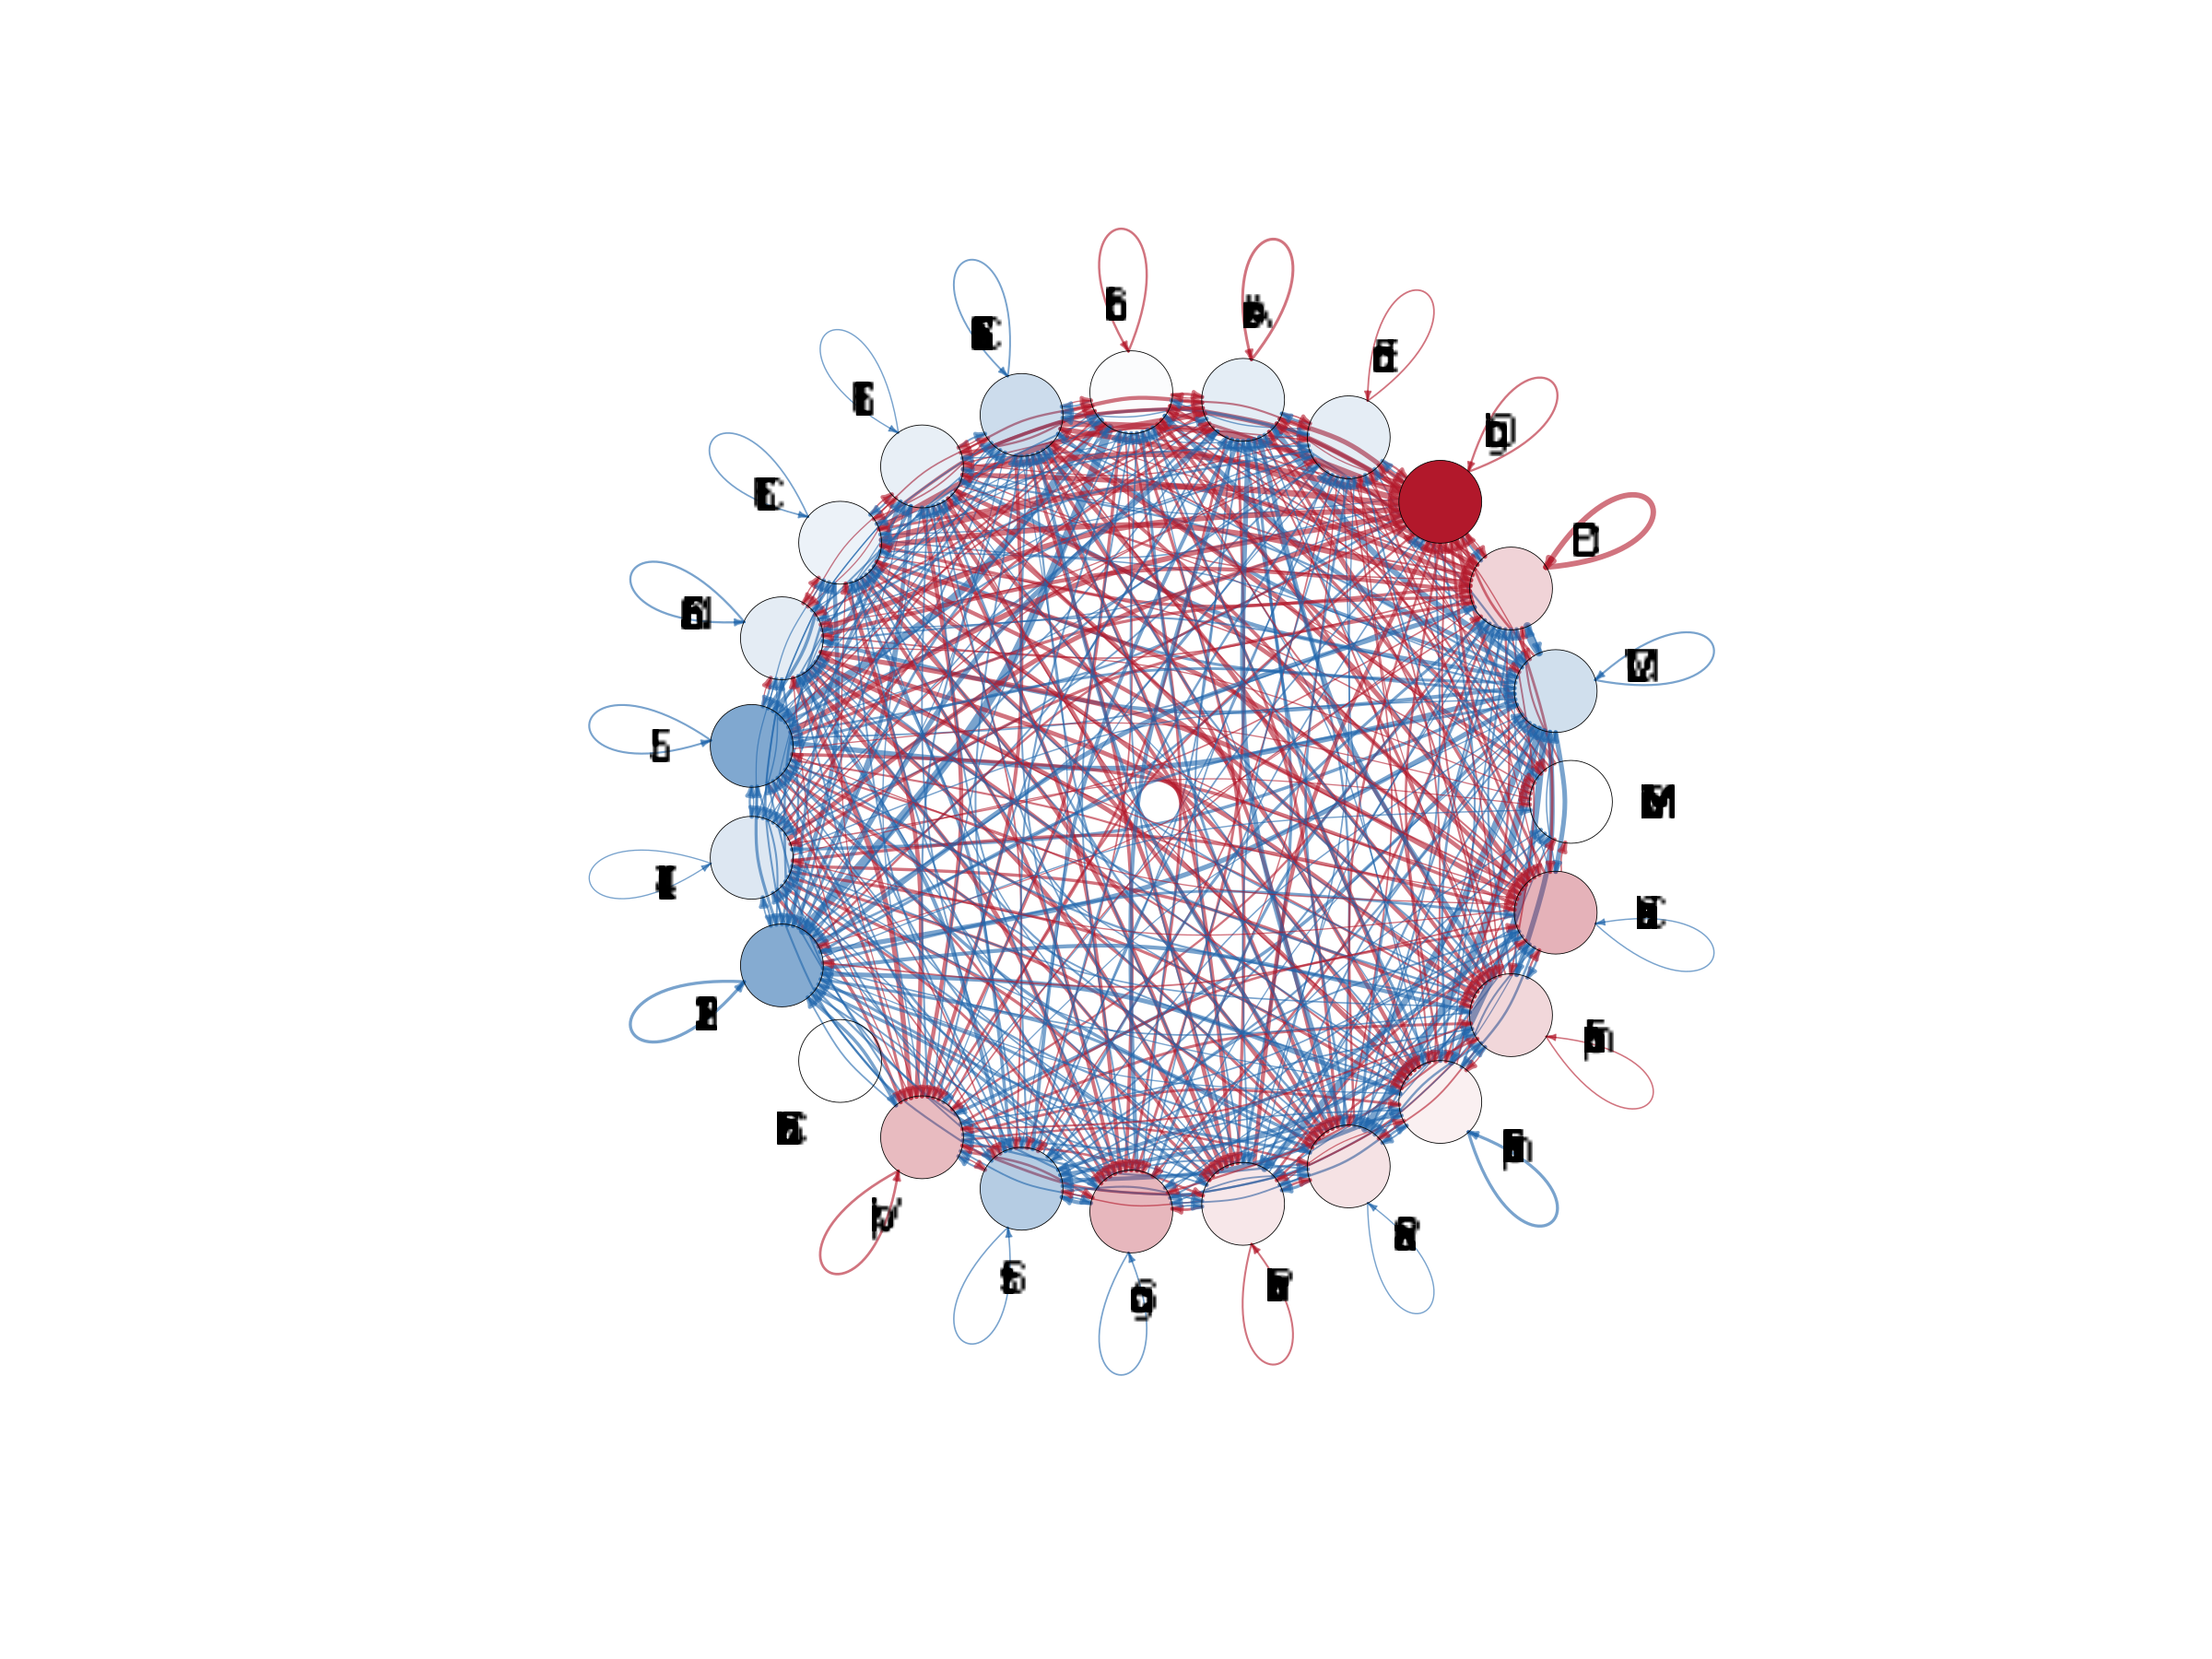

In [34]:
direction = "input"
x_dis = myVisual_diffInteraction(cellchat, rev(celltype_name), measure = "weight", weight.scale = T, node.color=direction, 
                             vertex.label.cex=0, edge.width.max=2, title.cex=4, title=F)

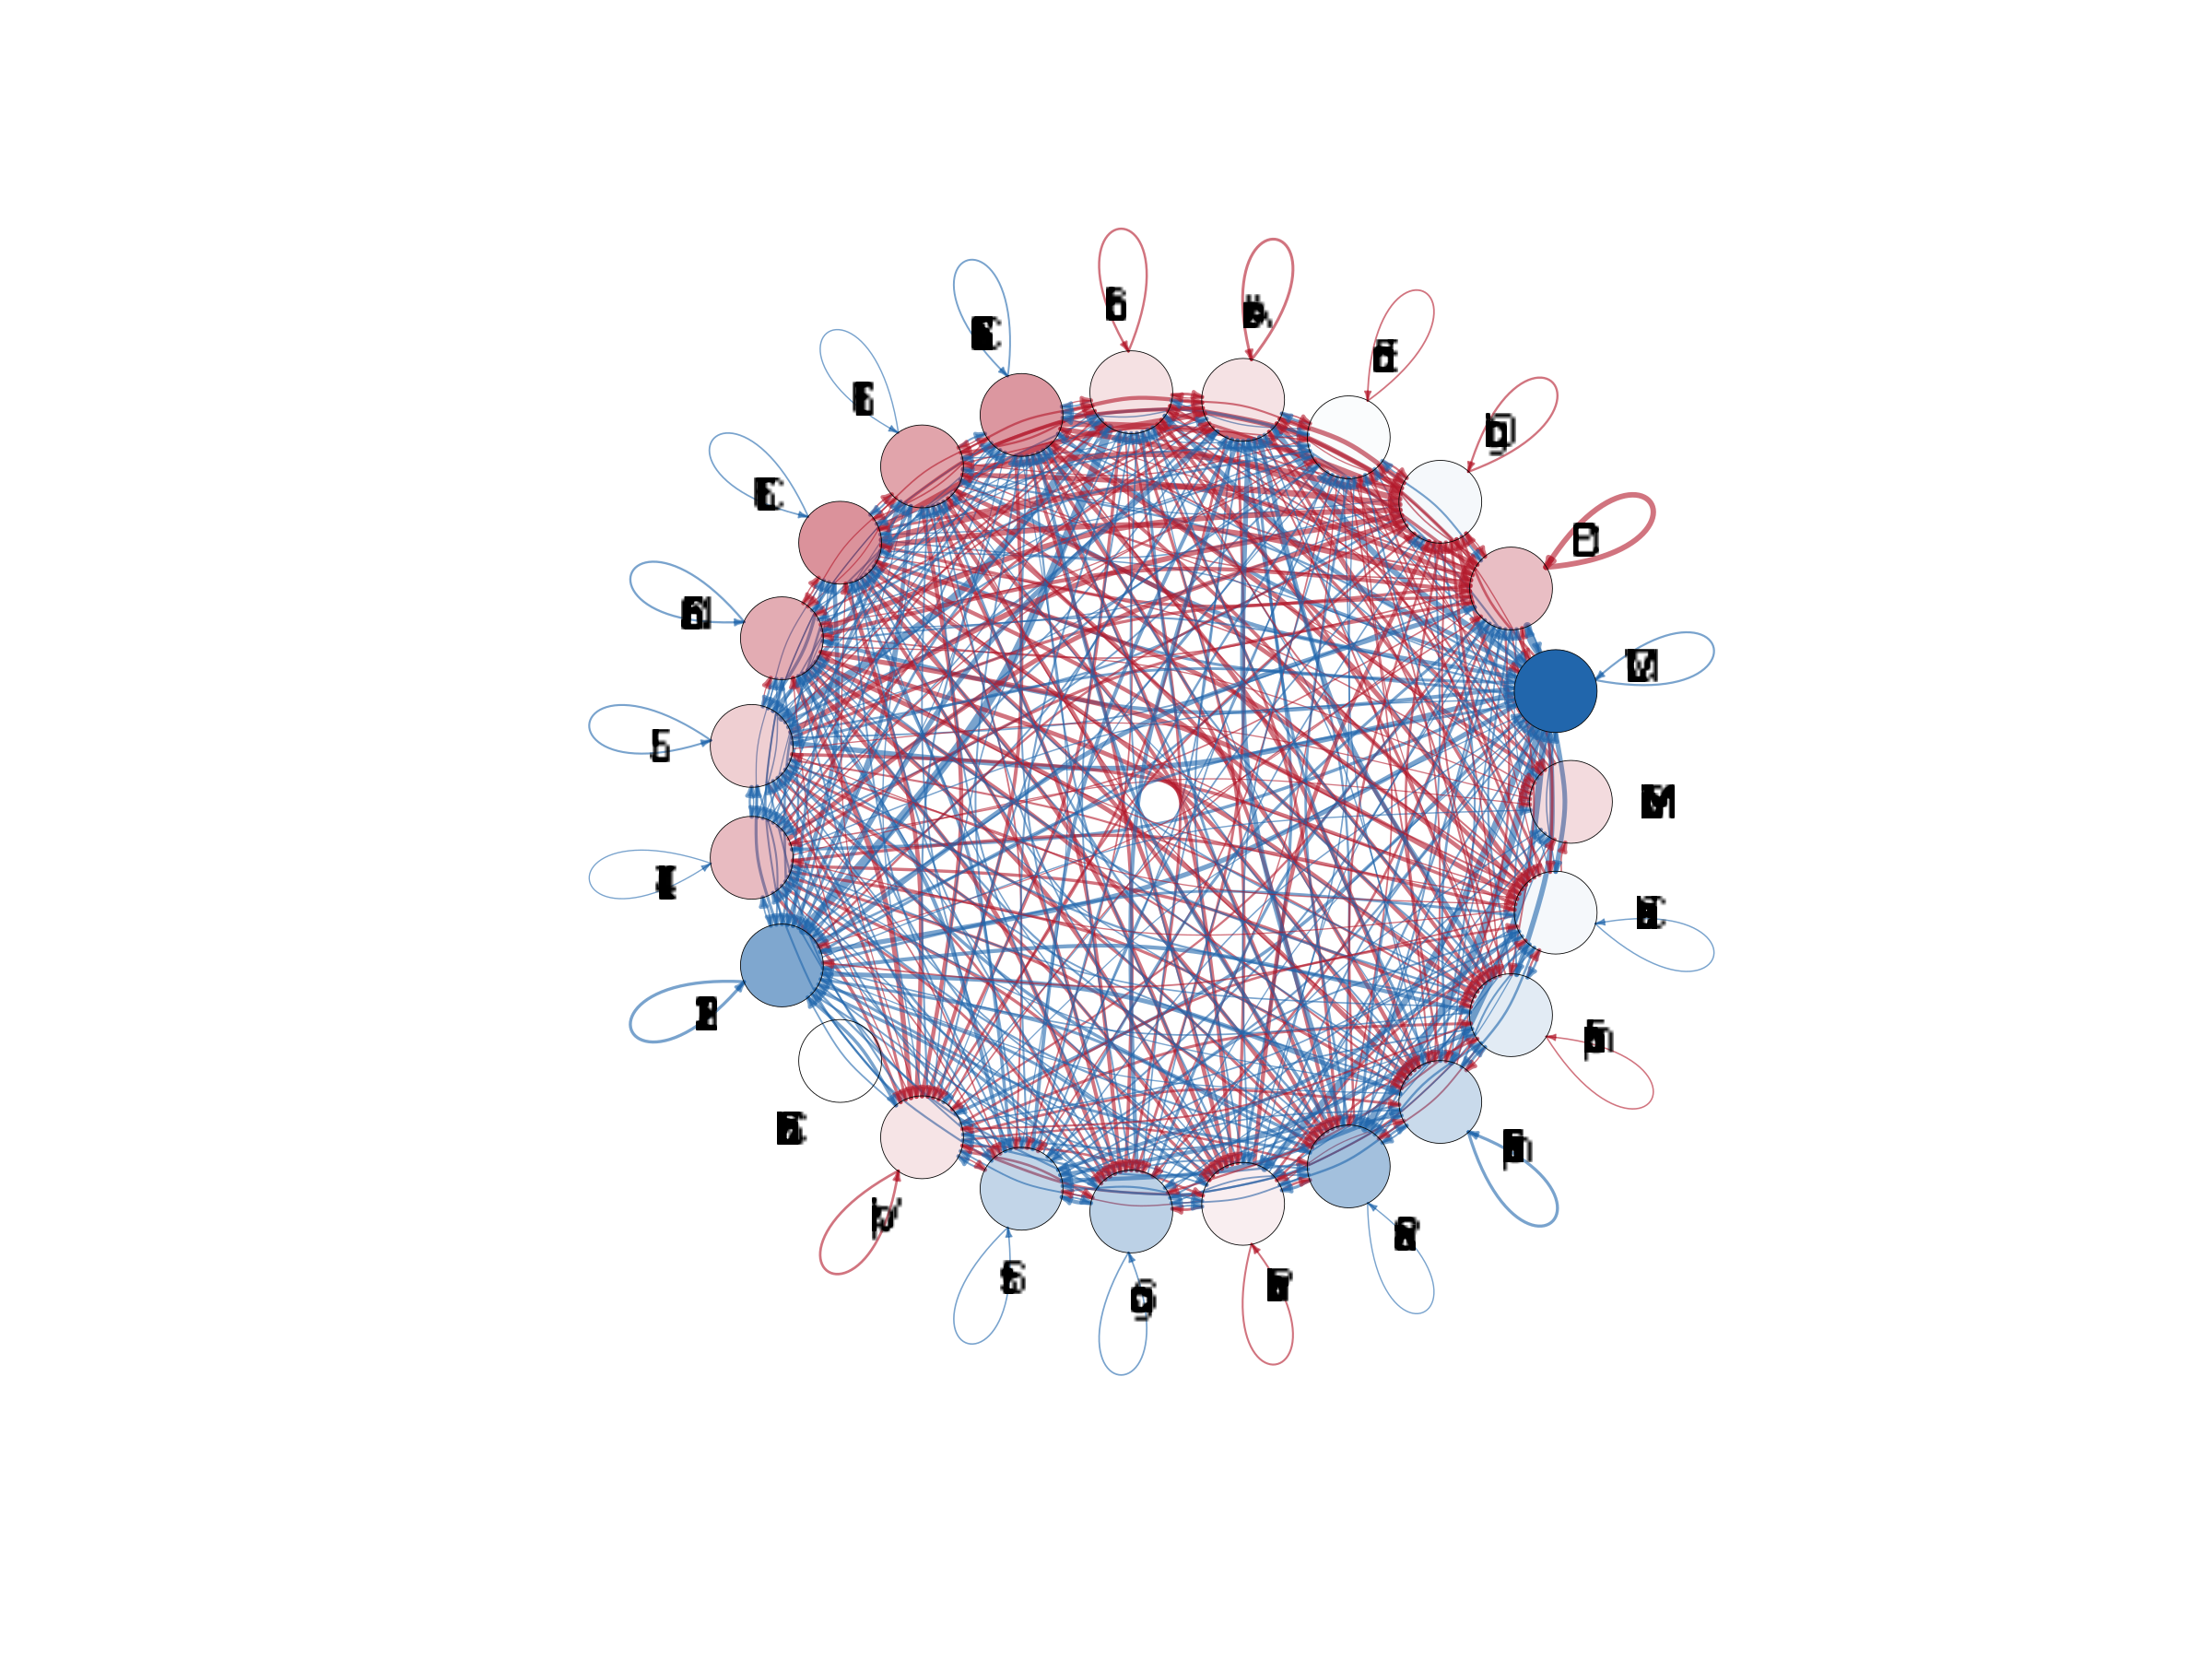

In [35]:
direction = "output"
x_con = myVisual_diffInteraction(cellchat, rev(celltype_name), measure = "weight", weight.scale = T, node.color=direction, 
                             vertex.label.cex=0, edge.width.max=2, title.cex=4, title=F)

# Code

In [23]:
# Paramter
pathways.show      <- "NRG" # "NRG"
sender_celltypes   <- celltype_name
receiver_celltypes <- "Oligo" # "Inh SST"
LR_pairs      <- searchPair(signaling = pathways.show, pairLR.use = cellchat.CT@LR$LRsig, key = "pathway_name", matching.exact = T, pair.only = T)$interaction_name     

# Don't change. Hard-coded
matrix.CT     <- cellchat.CT@net$prob        # 14 x 14 x 946
matrix.DIS    <- cellchat.DIS@net$prob       # 14 x 14 x 943
normalization <- sum(cellchat.CT@net$weight) / sum(cellchat.DIS@net$weight)  # CT / DIS, obtained from the 14x14 cell type matrix

print(paste0("For CT,   are all LR pairs in database found in C2C matrix? : ", all(LR_pairs %in% dimnames(matrix.CT)[[3]])))
print(paste0("For DIS, are all LR pairs in database found in C2C matrix? : ", all(LR_pairs %in% dimnames(matrix.DIS)[[3]])))
LR_pairs <- intersect(LR_pairs[LR_pairs %in% dimnames(matrix.CT)[[3]]], LR_pairs[LR_pairs %in% dimnames(matrix.DIS)[[3]]])

[1] "For CT,   are all LR pairs in database found in C2C matrix? : TRUE"
[1] "For DIS, are all LR pairs in database found in C2C matrix? : TRUE"


In [24]:
sender_celltypes

[1] "Chandelier" "Lamp5"      "Lamp5 Lhx6" "Pax6"       "Pvalb"     
 [6] "Sncg"       "Sst"        "Vip"        "Sst Chodl"  "L2/3 IT"   
[11] "L4 IT"      "L5"         "L5/6 NP"    "L6 CT"      "L6 IT"     
[16] "L6 IT Car3" "L6b"        "Astro"      "Endo"       "Oligo"     
[21] "OPC"        "VLMC"       "Micro/PVM"

In [25]:
receiver_celltypes

[1] "Oligo"

In [26]:
LR_pairs

[1] "NRG1_ERBB3"       "NRG1_ERBB2_ERBB3" "NRG1_ERBB4"       "NRG1_ERBB2_ERBB4"
 [5] "NRG2_ERBB3"       "NRG2_ERBB2_ERBB3" "NRG2_ERBB4"       "NRG2_ERBB2_ERBB4"
 [9] "NRG3_ERBB4"       "NRG3_ERBB2_ERBB4" "NRG4_ERBB4"       "NRG4_ERBB2_ERBB4"
[13] "NRG1_ITGAV_ITGB3"

In [27]:
#LR_pairs_weight.CT <- NULL
#LR_pairs_weight.DIS <- NULL
#LR_pairs_weight.differential <- NULL

In [28]:
# if statement needed for 2D-matrices with only 1 ligand-receptor pair
if ((length(LR_pairs) > 1) & (length(sender_celltypes)) > 1 & (length(receiver_celltypes) > 1)) {
    LR_pairs_weight.CT           <- apply(matrix.CT[sender_celltypes]+matrix.CT[receiver_celltypes]+matrix.CT[LR_pairs], c(3), sum)
    LR_pairs_weight.DIS          <- apply(matrix.DIS[sender_celltypes]+matrix.DIS[receiver_celltypes]+matrix.DIS[LR_pairs], c(3), sum)
    LR_pairs_weight.differential <- LR_pairs_weight.DIS * normalization - LR_pairs_weight.CT        # DIS - CON
} else if (length(LR_pairs) == 1) {
    LR_pairs_weight.CT           <- sum(matrix.CT[sender_celltypes, receiver_celltypes, LR_pairs])
    LR_pairs_weight.DIS          <- sum(matrix.DIS[sender_celltypes, receiver_celltypes, LR_pairs])
    LR_pairs_weight.differential <- LR_pairs_weight.DIS * normalization - LR_pairs_weight.CT        # DIS - CON
    names(LR_pairs_weight.differential) <- LR_pairs
} else if ((length(sender_celltypes)) == 1 || (length(receiver_celltypes) == 1)) {
    LR_pairs_weight.CT           <- apply(matrix.CT[sender_celltypes, receiver_celltypes, LR_pairs], c(2), sum)
    LR_pairs_weight.DIS          <- apply(matrix.DIS[sender_celltypes, receiver_celltypes, LR_pairs], c(2), sum)
    LR_pairs_weight.differential <- LR_pairs_weight.DIS * normalization - LR_pairs_weight.CT        # DIS - CON
}

# Visual

In [29]:
LR_pairs_weight.differential <- LR_pairs_weight.differential[LR_pairs_weight.differential != 0]

In [30]:
if (length(receiver_celltypes) == 1) {
    direction <- "to"
    cell_type <- receiver_celltypes[1]
} else {
    direction <- "from"
    cell_type <- sender_celltypes[1]
}

In [31]:
# Barplot
pdf(file = glue("LRpairs-{direction}_{cell_type}-{pathways.show}-{disease}.pdf"), width = 8, height = 8)
par(mar = c(5, 15, 4, 2))
barplot(LR_pairs_weight.differential, main = glue("{disease} - CON"), xlab = "Communication Differential Strength", ylab = "", 
                 col = "steelblue", horiz = TRUE, las=1)
dev.off()

png 
  2